# Converting Clothes Image Classifier into an Object Detector

## Import libraries

In [63]:
import imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
import imutils
from imutils.object_detection import non_max_suppression
import time
from tensorflow import keras
import tensorflow_hub as hub
import keras_utils


## Import class labels

In [31]:
import json
file = open('classes.json')
classes = json.load(file)

classes = {int(k):v for k,v in classes.items()}
print(classes)
file.close()

{0: 'Blazer False', 1: 'Blazer True', 2: 'Blouse False', 3: 'Body False', 4: 'Body True', 5: 'Dress False', 6: 'Dress True', 7: 'Hat False', 8: 'Hat True', 9: 'Hoodie False', 10: 'Hoodie True', 11: 'Longsleeve False', 12: 'Longsleeve True', 13: 'Not_sure False', 14: 'Not_sure True', 15: 'Other False', 16: 'Other True', 17: 'Outwear False', 18: 'Outwear True', 19: 'Pants False', 20: 'Pants True', 21: 'Polo False', 22: 'Polo True', 23: 'Shirt False', 24: 'Shirt True', 25: 'Shoes False', 26: 'Shoes True', 27: 'Shorts False', 28: 'Shorts True', 29: 'Skip False', 30: 'Skip True', 31: 'Skirt False', 32: 'Skirt True', 33: 'T-Shirt False', 34: 'T-Shirt True', 35: 'Top False', 36: 'Top True', 37: 'Undershirt False', 38: 'Undershirt True'}


## Conversion Process

1. Enter an image
2. Make an image pyramid.
3. Run a sliding window for each scale of the image pyramid.
    Calculate the ROIs for each stop of the sliding window.
    Pass the ROIs through our CNN that was originally trained for image classification.
    Examine the likelihood of the CNN's top class label, and if it meets a minimum confidence level, record (1) the class label and (2) the location of the sliding window.
4. Apply non-maxima suppression to the bounding boxes on a class-by-class basis.
5. Return the results to the calling function.

In [162]:
# image: path to the input image
# size: ROI size
# min_confidence: non-maxima suppression probability 

args = {'image':"shirt_1.png", 'size': (200, 200), 'min_confidence':0.9999}

### Sliding Window

In [125]:
def sliding_window(image, step, win_step):
    #slide a window of win_step size over the image
    for y in range(0, image.shape[0]-win_step[1], step):
        for x in range(0, image.shape[1] - win_step[0], step):
            yield (x, y, image[y:y + win_step[1], x:x + win_step[0]])

### Image Pyramid

In [124]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w) 
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [171]:
WIDTH = 700 
PYR_SCALE = 1.5
WINDOW_STEP = 20*3 
ROI_SIZE = args["size"]
INPUT_SIZE = (224, 224)

### Loading Previously trained model

In [12]:
print("[INFO] loading network...")
model =  tf.keras.models.load_model(
       ('model_ResNet50.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)
print('...done')

[INFO] loading network...
...done


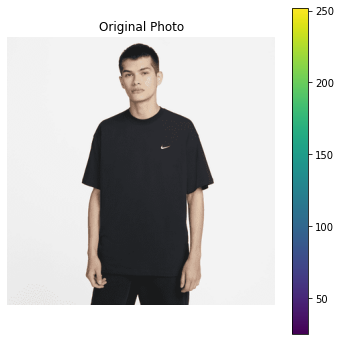

In [172]:
image = cv2.imread(args["image"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
ax.set_title("Original Photo")
plt.imshow(image)
plt.axis("off")
plt.colorbar()

In [173]:
original_image = image
original_image = imutils.resize(original_image, width = WIDTH)
(H, W) = original_image.shape[:2]

### Extracting ROIs

In [174]:
pyramid = image_pyramid(original_image, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image pyramid 
# and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()
counter = 0
total_images = 0
for p, image in enumerate(pyramid):
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    sw = 0
    for (x, y, roi_original) in sliding_window(image, WINDOW_STEP, ROI_SIZE):
        sw = sw + 1
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)
        # take the ROI and pre-process it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roi_original, INPUT_SIZE)
        roi = tf.keras.preprocessing.image.img_to_array(roi)
        roi = tf.keras.applications.resnet.preprocess_input(roi)
        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
        
         # clone the original image and then draw a bounding box
        # surrounding the current region
        clone = original_image.copy()
        cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 5)
        total_images = total_images +1

end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
print("Total images {:.2f}".format(total_images))

[INFO] looping over pyramid/windows took 0.08869 seconds
Total images 111.00


### Classifying ROIs

In [175]:
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
my_preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

[INFO] classifying ROIs...
[INFO] classifying ROIs took 2.64990 seconds


In [176]:
preds = []
for i in range(my_preds.shape[0]):
    preds.append((classes[np.argmax(my_preds[i], axis=-1)], max(my_preds[i])))

### Displaying results

[INFO] showing results for 'Hoodie False'
[INFO] showing results for 'T-Shirt False'
[INFO] showing results for 'Longsleeve False'
[INFO] showing results for 'Not_sure False'
[INFO] showing results for 'Skirt False'


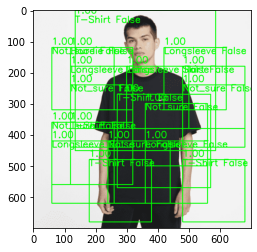

In [180]:
labels = {}
# loop over the predictions
for (i, p) in enumerate(preds):
    # grab the prediction information for the current ROI
    (label, prob) = p

    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= args["min_confidence"]:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i]

        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L
        allclone = original_image.copy()
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = original_image.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

    clone = original_image.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        cv2.rectangle(allclone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(clone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(allclone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(allclone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)        

plt.imshow(allclone)
#plt.imsave("prediction_result_clone.jpg", allclone)